## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import prophet as prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet import Prophet

c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Notebook settings

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

sns.set_theme(style='white', palette='Blues_r')

### Functions

### Reading in data

In [34]:
df_actual = pd.read_csv('../05.output/actual/actual.csv')
df_breaches = pd.read_csv('../05.output/actual/breaches_for_forecasting.csv')
df_waiting = pd.read_csv('../05.output/actual/waiting_list_for_forecasting.csv')

## New demand

### Preprocessing the data

In [4]:
# Checking datatypes and any missing values
df_actual[['week', 'new_demand']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   week        94 non-null     object 
 1   new_demand  94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


- 'week' is currently an object not datatime
- There are no missing values in week or new_demand

In [5]:
# Converting week to datetime

df_actual['week'] = pd.to_datetime(df_actual['week'])

In [6]:
# Checking dates are equidistant

df_actual['week_diff'] = df_actual['week'].diff()

df_actual['week_diff'].unique()

<TimedeltaArray>
[NaT, '7 days']
Length: 2, dtype: timedelta64[ns]

In [9]:
# Checking dates are in chronological order

df_actual['week']

0    2022-04-03
1    2022-04-10
2    2022-04-17
3    2022-04-24
4    2022-05-01
        ...    
89   2023-12-17
90   2023-12-24
91   2023-12-31
92   2024-01-07
93   2024-01-14
Name: week, Length: 94, dtype: datetime64[ns]

- All dates are 7 days apart, so are equidistant, and they are in chronological order

In [13]:
# Creating a dataframe with two columns named to match Prophet's requirements
df_new_demand = df_actual[['week', 'new_demand']]
df_new_demand.columns = ['ds', 'y']
df_new_demand

,ds,y
0,2022-04-03,1403.6
1,2022-04-10,1416.8
2,2022-04-17,1117.6
3,2022-04-24,1028.5
4,2022-05-01,1173.7
...,...,...
89,2023-12-17,1252.9
90,2023-12-24,1433.3
91,2023-12-31,826.1
92,2024-01-07,998.8


### Forecasting new demand

In [14]:
# Fitting the model
model = Prophet()
model.fit(df_new_demand)

10:45:35 - cmdstanpy - INFO - Chain [1] start processing
10:45:35 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Allocating time periods to training, validating and testing
df_train_new_demand = df_new_demand[(df_new_demand['ds'] <= '2023-05-21')]
df_validate_new_demand = df_new_demand[(df_new_demand['ds'] > '2023-05-21') &(df_new_demand['ds'] <= '2023-10-08')]
df_test_new_demand = df_new_demand[(df_new_demand['ds'] > '2023-10-08')]

#### Validation

In [17]:
# Predicting new demand for the validate period
forecast = model.predict(df_validate_new_demand)

In [19]:
# Displaying the first five y predictions and upper and lower bounds for the validate period
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2023-05-28  1250.591250  1059.620608  1456.033899
1 2023-06-04  1250.780312  1056.774853  1446.747157
2 2023-06-11  1250.969374  1046.502906  1456.944884
3 2023-06-18  1251.158436  1044.705245  1436.103272
4 2023-06-25  1251.347498  1053.590809  1453.471007


c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


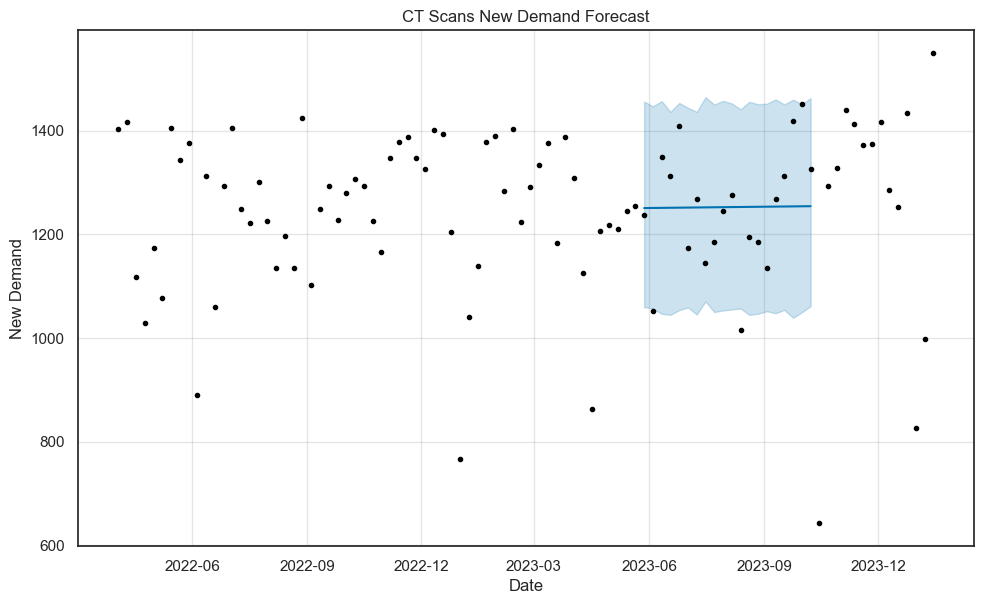

In [20]:
# Plotting the data to see how well the predictions fit the actual values
fig = model.plot(forecast, xlabel='Date', ylabel='New Demand')
ax = fig.gca()
ax.set_title('CT Scans New Demand Forecast')
plt.show()

In [22]:
# Calculating the mean average error for the validate period
y_true = df_validate_new_demand['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

MAE: 90.96


- The mean absolute error across the validate period is approx. 91 CT scans

In [23]:
# Calculating the mean squared error for the validate period
y_true = df_validate_new_demand['y'].values
y_pred = forecast['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' % mse)

MSE: 12725.24


- The mean squared error across the validate period is approx. 12725

In [24]:
# Calculating the R squared value for the test period
y_true = df_validate_new_demand['y'].values
y_pred = forecast['yhat'].values
r2 = r2_score(y_true, y_pred)
print('R2: %.2f' % r2)

R2: 0.00


- The R squared for the validate period is 0 (i.e., the model does not explain any of the variability in the data during this time period)
- This can be seen from the graph above, as the predicted values are in a straight, almost flat line, whereas the actual values vary between just over 1000 and more than 1400

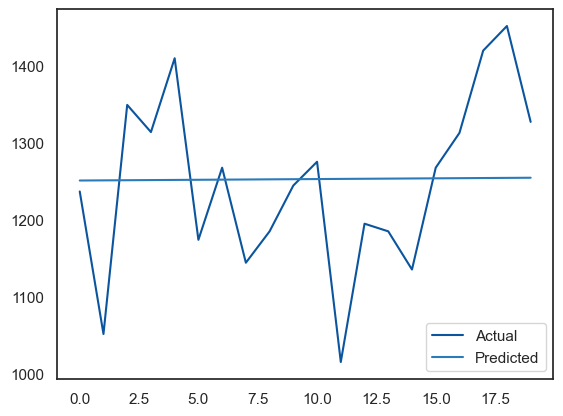

In [25]:
# Plotting the actual v. predicted new demand for the validate period
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- The model is not able to predict the week-to-week variability in the data

#### Test

In [26]:
# Predicting new demand for the test period
forecast_test = model.predict(df_test_new_demand)

In [27]:
# Displaying the first five y predictions and upper and lower bounds for the validate period
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2023-10-15  1254.372493  1050.009403  1446.531485
1 2023-10-22  1254.561555  1045.589978  1465.270211
2 2023-10-29  1254.750618  1064.844130  1451.624044
3 2023-11-05  1254.939680  1042.955050  1454.594129
4 2023-11-12  1255.128742  1060.545576  1451.957503


c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


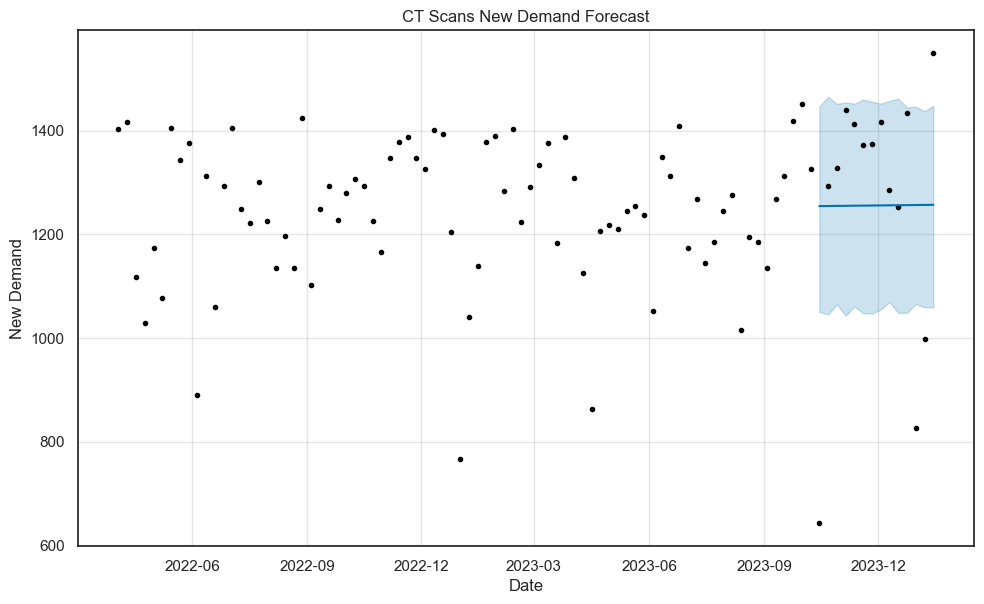

In [28]:
# Plotting the data to see how well the predictions fit the actual values
fig = model.plot(forecast_test, xlabel='Date', ylabel='New Demand')
ax = fig.gca()
ax.set_title('CT Scans New Demand Forecast')
plt.show()

In [29]:
# Calculating the mean average error for the validate period
y_true = df_test_new_demand['y'].values
y_pred = forecast_test['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

MAE: 189.30


- The mean absolute error across the test period is approx. 189 CT scans

In [30]:
# Calculating the mean squared error for the validate period
y_true = df_test_new_demand['y'].values
y_pred = forecast_test['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' % mse)

MSE: 61533.96


- The mean squared error across the test period is approx. 61534

In [31]:
# Calculating the R squared value for the test period
y_true = df_test_new_demand['y'].values
y_pred = forecast_test['yhat'].values
r2 = r2_score(y_true, y_pred)
print('R2: %.2f' % r2)

R2: 0.00


- The R squared for the test period is 0 (i.e., the model does not explain any of the variability in the data during this time period)
- This can be seen from the graph above, as the predicted values are in a straight, almost flat line, whereas the actual values vary between just over 600 and nearly 1500

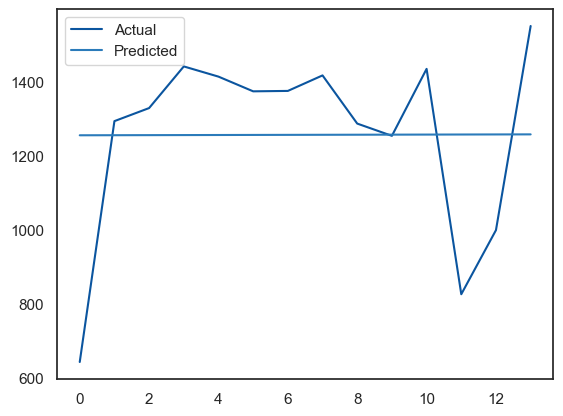

In [32]:
# Plotting the actual v. predicted new demand for the validate period
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- The model is not able to predict the week-to-week variability in the data

## Waiting list

### Preprocessing the data

In [37]:
# Checking datatypes and any missing values
df_waiting[['Unnamed: 0', 'waiting_list']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    227 non-null    object 
 1   waiting_list  227 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB


- Week column is currently an object not datatime
- There are no missing values in week or waiting_list

In [38]:
# Converting week to datetime

df_waiting['Unnamed: 0'] = pd.to_datetime(df_waiting['Unnamed: 0'])

In [39]:
# Checking dates are equidistant

df_waiting['Unnamed: 0_diff'] = df_waiting['Unnamed: 0'].diff()

df_waiting['Unnamed: 0_diff'].unique()

<TimedeltaArray>
[NaT, '7 days']
Length: 2, dtype: timedelta64[ns]

In [40]:
# Checking dates are in chronological order

df_waiting['Unnamed: 0']

0     2019-09-15
1     2019-09-22
2     2019-09-29
3     2019-10-06
4     2019-10-13
         ...    
222   2023-12-17
223   2023-12-24
224   2023-12-31
225   2024-01-07
226   2024-01-14
Name: Unnamed: 0, Length: 227, dtype: datetime64[ns]

- All dates are 7 days apart, so are equidistant, and they are in chronological order

In [42]:
# Creating a dataframe with two columns named to match Prophet's requirements
df_waiting_list = df_waiting[['Unnamed: 0', 'waiting_list']]
df_waiting_list.columns = ['ds', 'y']
df_waiting_list

,ds,y
0,2019-09-15,2660.9
1,2019-09-22,2567.4
2,2019-09-29,2699.4
3,2019-10-06,2884.2
4,2019-10-13,2863.3
...,...,...
222,2023-12-17,5845.4
223,2023-12-24,5926.8
224,2023-12-31,5580.3
225,2024-01-07,5398.8


### Forecasting waiting list

In [60]:
# Fitting the model
model = Prophet()
model.fit(df_waiting_list)

11:35:33 - cmdstanpy - INFO - Chain [1] start processing
11:35:33 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
# Allocating time periods to training, validating and testing
df_train_waiting = df_waiting_list[(df_waiting_list['ds'] >= '2019-09-15') & (df_waiting_list['ds'] <= '2022-09-15')]
df_validate_waiting = df_waiting_list[(df_waiting_list['ds'] > '2022-09-15') &(df_waiting_list['ds'] <= '2023-09-16')]
df_test_waiting = df_waiting_list[(df_waiting_list['ds'] > '2023-09-16')]

#### Validation

In [46]:
# Predicting new demand for the validate period
forecast_waiting = model.predict(df_validate_waiting)

In [47]:
# Displaying the first five y predictions and upper and lower bounds for the validate period
print(forecast_waiting[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2022-09-18  4373.325673  3584.505960  5145.589536
1 2022-09-25  4406.051939  3595.500592  5190.057961
2 2022-10-02  4430.770146  3639.404985  5197.425653
3 2022-10-09  4463.023232  3655.272148  5239.785386
4 2022-10-16  4503.138059  3724.950796  5314.593484


c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


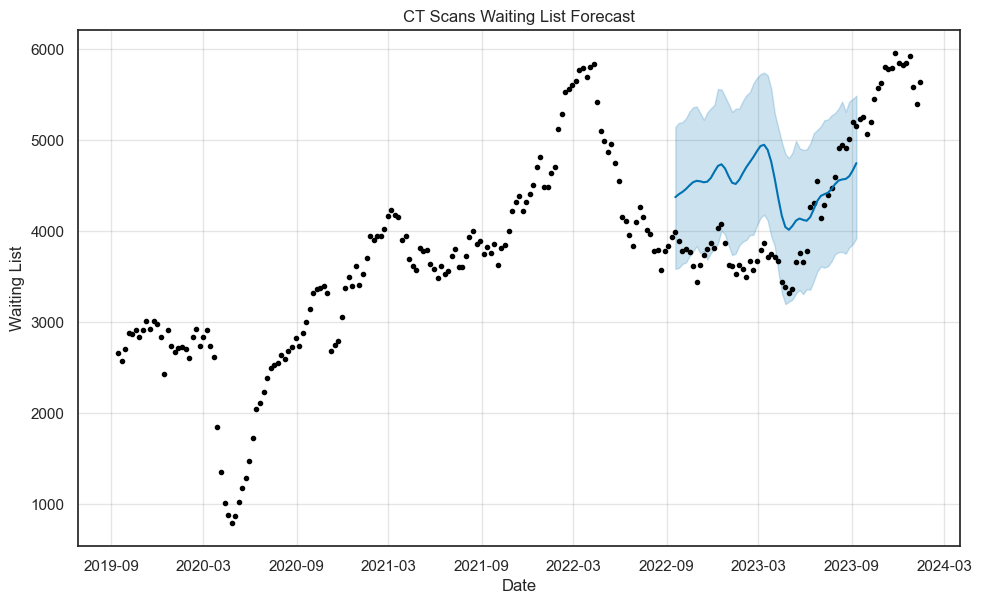

In [48]:
# Plotting the data to see how well the predictions fit the actual values
fig = model.plot(forecast_waiting, xlabel='Date', ylabel='Waiting List')
ax = fig.gca()
ax.set_title('CT Scans Waiting List Forecast')
plt.show()

In [49]:
# Calculating the mean average error for the validate period
y_true = df_validate_waiting['y'].values
y_pred = forecast_waiting['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

MAE: 663.25


- The mean absolute error across the validate period is approx. 663 patients

In [50]:
# Calculating the mean squared error for the validate period
y_true = df_validate_waiting['y'].values
y_pred = forecast_waiting['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' % mse)

MSE: 558400.99


- The mean squared error across the validate period is approx. 558401

In [51]:
# Calculating the R squared value for the test period
y_true = df_validate_waiting['y'].values
y_pred = forecast_waiting['yhat'].values
r2 = r2_score(y_true, y_pred)
print('R2: %.2f' % r2)

R2: -1.35


- The R squared for the validate period is -1.35 (this is not between 0 and 1 as expected and indicates the model is not a good one)

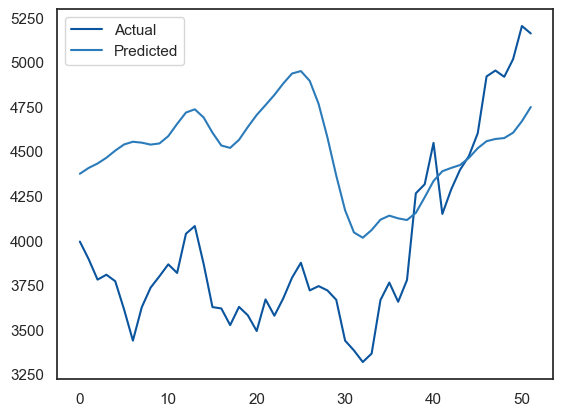

In [52]:
# Plotting the actual v. predicted waiting list for the validate period
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- The predicted waiting list follows a similiar-ish trend to the actual, but the values are quite a way off

#### Test

In [53]:
# Predicting new demand for the test period
forecast_waiting_test = model.predict(df_test_waiting)

In [54]:
# Displaying the first five y predictions and upper and lower bounds for the validate period
print(forecast_waiting_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2023-09-17  4813.113849  4017.651514  5621.317439
1 2023-09-24  4855.238720  4047.780627  5606.073449
2 2023-10-01  4886.013060  4108.931121  5663.627154
3 2023-10-08  4922.403837  4164.813224  5688.208881
4 2023-10-15  4967.886158  4174.649071  5745.064526


c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


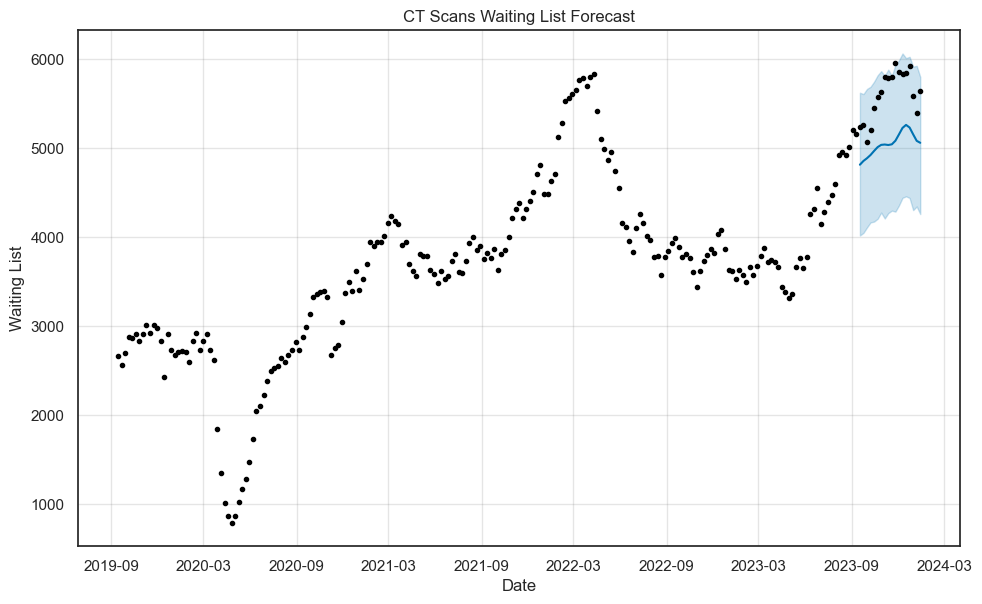

In [55]:
# Plotting the data to see how well the predictions fit the actual values
fig = model.plot(forecast_waiting_test, xlabel='Date', ylabel='Waiting List')
ax = fig.gca()
ax.set_title('CT Scans Waiting List Forecast')
plt.show()

In [56]:
# Calculating the mean average error for the validate period
y_true = df_test_waiting['y'].values
y_pred = forecast_waiting_test['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

MAE: 553.98


- The mean absolute error across the test period is approx. 554 patients

In [57]:
# Calculating the mean squared error for the validate period
y_true = df_test_waiting['y'].values
y_pred = forecast_waiting_test['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' % mse)

MSE: 340375.57


- The mean squared error across the test period is approx. 340376

In [58]:
# Calculating the R squared value for the test period
y_true = df_test_waiting['y'].values
y_pred = forecast_waiting_test['yhat'].values
r2 = r2_score(y_true, y_pred)
print('R2: %.2f' % r2)

R2: -3.78


- The R squared for the test period is -3.78 (this isn't between 0 and 1, which suggests the model is very poor)

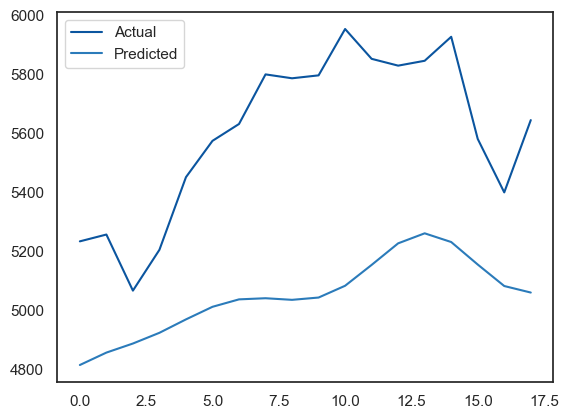

In [59]:
# Plotting the actual v. predicted new demand for the validate period
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- The model does not seem to be a good fit

## Breaches

### Preprocessing the data

In [63]:
# Checking datatypes and any missing values
df_breaches[['Unnamed: 0', 'breaches']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  227 non-null    object 
 1   breaches    227 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB


- Week column is currently an object not datatime
- There are no missing values in week or breaches

In [64]:
# Converting week to datetime

df_breaches['Unnamed: 0'] = pd.to_datetime(df_breaches['Unnamed: 0'])

In [65]:
# Checking dates are equidistant

df_breaches['Unnamed: 0_diff'] = df_breaches['Unnamed: 0'].diff()

df_breaches['Unnamed: 0_diff'].unique()

<TimedeltaArray>
[NaT, '7 days']
Length: 2, dtype: timedelta64[ns]

In [66]:
# Checking dates are in chronological order

df_breaches['Unnamed: 0']

0     2019-09-15
1     2019-09-22
2     2019-09-29
3     2019-10-06
4     2019-10-13
         ...    
222   2023-12-17
223   2023-12-24
224   2023-12-31
225   2024-01-07
226   2024-01-14
Name: Unnamed: 0, Length: 227, dtype: datetime64[ns]

- All dates are 7 days apart, so are equidistant, and they are in chronological order

In [67]:
# Creating a dataframe with two columns named to match Prophet's requirements
df_breaches = df_breaches[['Unnamed: 0', 'breaches']].copy()
df_breaches.columns = ['ds', 'y']
df_breaches

,ds,y
0,2019-09-15,73.7
1,2019-09-22,45.1
2,2019-09-29,18.7
3,2019-10-06,48.4
4,2019-10-13,61.6
...,...,...
222,2023-12-17,1551.0
223,2023-12-24,1647.8
224,2023-12-31,1729.2
225,2024-01-07,1630.2


### Forecasting breaches

In [68]:
# Fitting the model
model = Prophet()
model.fit(df_breaches)

11:38:44 - cmdstanpy - INFO - Chain [1] start processing
11:38:45 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# Allocating time periods to training, validating and testing
df_train_breaches = df_breaches[(df_breaches['ds'] >= '2019-09-15') & (df_breaches['ds'] <= '2022-09-15')]
df_validate_breaches = df_breaches[(df_breaches['ds'] > '2022-09-15') &(df_breaches['ds'] <= '2023-09-16')]
df_test_breaches = df_breaches[(df_breaches['ds'] > '2023-09-16')]

#### Validation

In [70]:
# Predicting new demand for the validate period
forecast_breaches = model.predict(df_validate_breaches)

In [71]:
# Displaying the first five y predictions and upper and lower bounds for the validate period
print(forecast_breaches[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2022-09-18  508.579265   25.607130  982.810213
1 2022-09-25  490.054463   45.850729  962.569036
2 2022-10-02  477.660861   34.151531  960.369393
3 2022-10-09  475.805670   22.177345  927.060093
4 2022-10-16  476.465004   18.280842  948.577596


c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


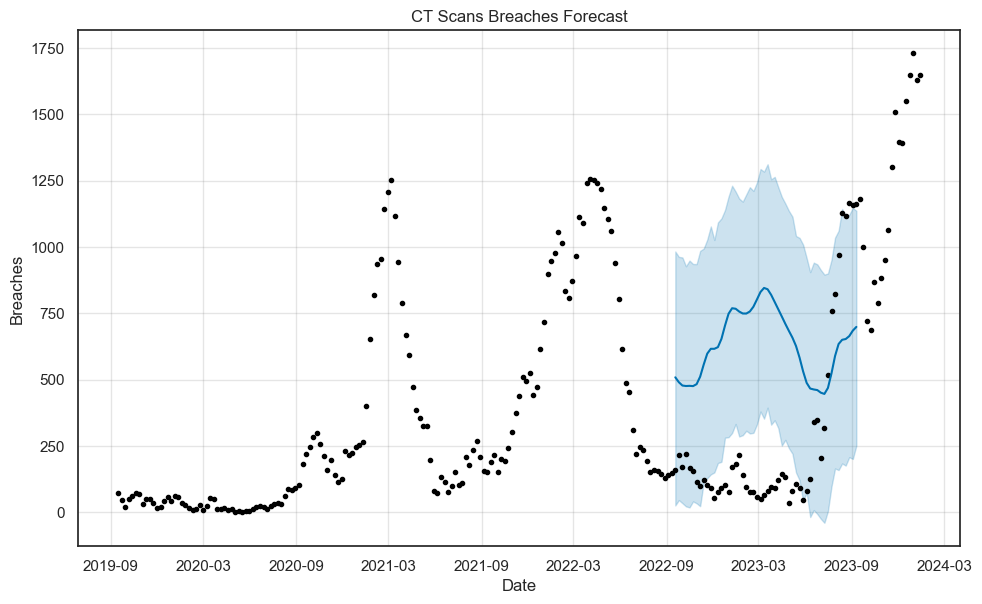

In [72]:
# Plotting the data to see how well the predictions fit the actual values
fig = model.plot(forecast_breaches, xlabel='Date', ylabel='Breaches')
ax = fig.gca()
ax.set_title('CT Scans Breaches Forecast')
plt.show()

In [73]:
# Calculating the mean average error for the validate period
y_true = df_validate_breaches['y'].values
y_pred = forecast_breaches['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

MAE: 480.54


- The mean absolute error across the validate period is approx. 481 breaches

In [74]:
# Calculating the mean squared error for the validate period
y_true = df_validate_breaches['y'].values
y_pred = forecast_breaches['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' % mse)

MSE: 264756.67


- The mean squared error across the validate period is approx. 264757

In [75]:
# Calculating the R squared value for the test period
y_true = df_validate_breaches['y'].values
y_pred = forecast_breaches['yhat'].values
r2 = r2_score(y_true, y_pred)
print('R2: %.2f' % r2)

R2: -1.29


- The R squared for the validate period is -1.29 (this is not between 0 and 1 as expected and indicates the model is not a good one)

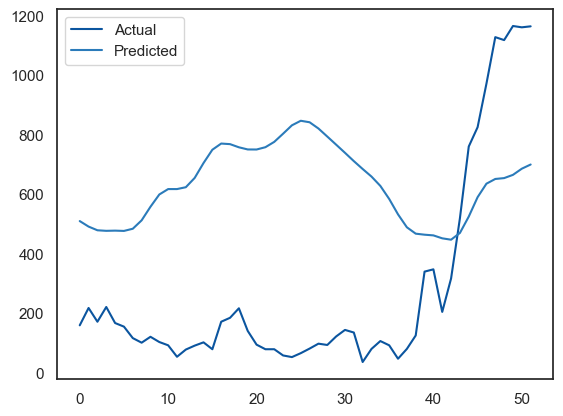

In [76]:
# Plotting the actual v. predicted breaches for the validate period
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- The predicted breaches do not appear to follow the same trend or variability as the actual breaches

#### Test

In [77]:
# Predicting new demand for the test period
forecast_breaches_test = model.predict(df_test_breaches)

In [78]:
# Displaying the first five y predictions and upper and lower bounds for the validate period
print(forecast_breaches_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower   yhat_upper
0 2023-09-17  693.430196  268.664288  1153.673384
1 2023-09-24  675.523638  185.909783  1116.919696
2 2023-10-01  661.334580  189.985221  1112.972672
3 2023-10-08  658.102988  205.874312  1100.662576
4 2023-10-15  659.077229  213.426741  1124.484422


c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mello\Documents\analytics\project_CT_scans\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


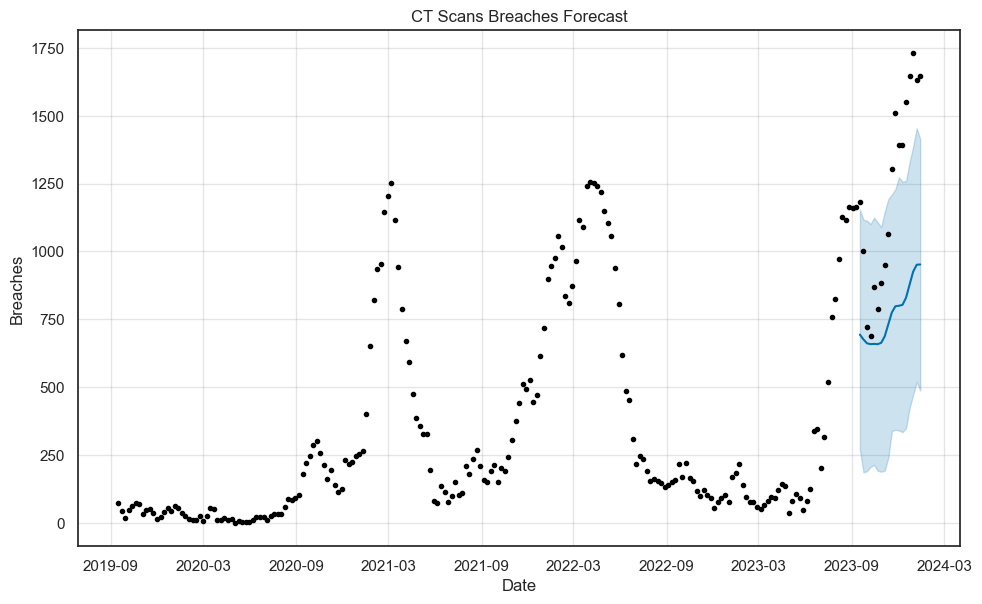

In [79]:
# Plotting the data to see how well the predictions fit the actual values
fig = model.plot(forecast_breaches_test, xlabel='Date', ylabel='Breaches')
ax = fig.gca()
ax.set_title('CT Scans Breaches Forecast')
plt.show()

In [80]:
# Calculating the mean average error for the test period
y_true = df_test_breaches['y'].values
y_pred = forecast_breaches_test['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

MAE: 452.93


- The mean absolute error across the test period is approx. 453 patients

In [81]:
# Calculating the mean squared error for the test period
y_true = df_test_breaches['y'].values
y_pred = forecast_breaches_test['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' % mse)

MSE: 268329.86


- The mean squared error across the test period is approx. 268330

In [82]:
# Calculating the R squared value for the test period
y_true = df_test_breaches['y'].values
y_pred = forecast_breaches_test['yhat'].values
r2 = r2_score(y_true, y_pred)
print('R2: %.2f' % r2)

R2: -1.24


- The R squared for the test period is -1.24 (this isn't between 0 and 1, which suggests the model is poor)

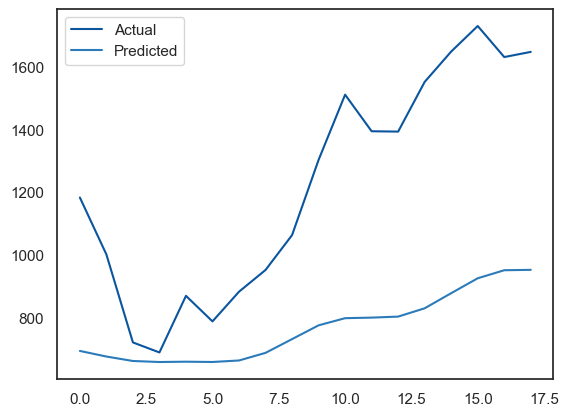

In [83]:
# Plotting the actual v. predicted new demand for the test period
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- The model does not seem to be a good fit